In [1]:
import numpy as np
import torch
from torch import optim
from torch import nn
from torch import distributions as dist
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T

from plot.plot_hist_loss import plot_loss
from plot.plot_posterior import plot_posterior
from simulate.simulate import simulate
from inference.flows import NormalizingFlow
from inference.loss import LossTeaching

from torchdyn.datasets import ToyDataset

In [2]:
sns.set()

In [3]:
%config InlineBackend.figure_format = "retina"

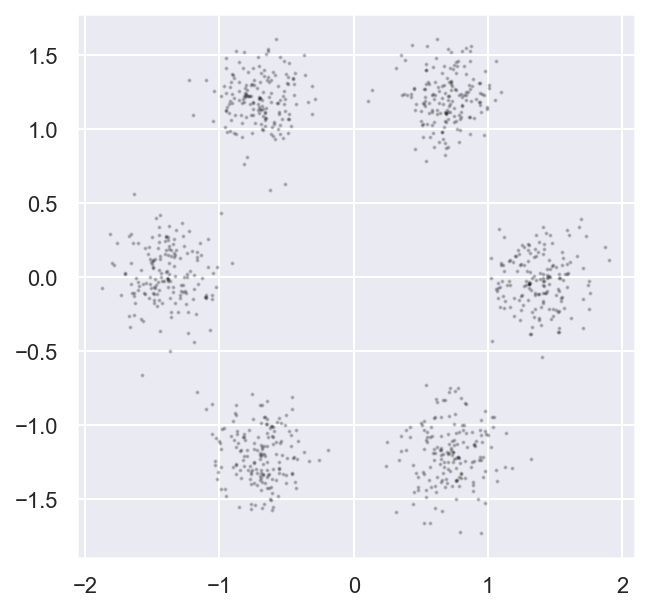

In [4]:
data = ToyDataset()
n_samples = 1000
n_gaussians = 6
X, yn = data.generate(n_samples // n_gaussians, 'gaussians', n_gaussians=6, std_gaussians=0.5, radius=4, dim=2)
X = (X - X.mean())/X.std()

import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], c='black', alpha=0.2, s=1.);

In [6]:
def autograd_trace(x_out, x_in, **kwargs):
    """Standard brute-force means of obtaining trace of the Jacobian, O(d) calls to autograd"""
    trJ = 0.
    for i in range(x_in.shape[1]):
        trJ += torch.autograd.grad(x_out[:, i].sum(), x_in, allow_unused=False, create_graph=True)[0][:, i]
    return trJ

def hutch_trace(x_out, x_in, noise=None, **kwargs):
    """Hutchinson's trace Jacobian estimator, O(1) call to autograd"""
    jvp = grad(x_out, x_in, noise, create_graph=True)[0]
    trJ = torch.einsum('bi,bi->b', jvp, noise)

    return trJ

REQUIRES_NOISE = [hutch_trace]


class CNF(nn.Module):
    def __init__(self, net, trace_estimator=None, noise_dist=None):
        super().__init__()
        self.net = net
        self.trace_estimator = trace_estimator if trace_estimator is not None else autograd_trace;
        self.noise_dist, self.noise = noise_dist, None
        if self.trace_estimator in REQUIRES_NOISE:
            assert self.noise_dist is not None, 'This type of trace estimator requires specification of a noise distribution'

    def forward(self, x):
        with torch.set_grad_enabled(True):
            x_in = torch.autograd.Variable(x[:,1:], requires_grad=True).to(x) # first dimension reserved to divergence propagation
            # the neural network will handle the data-dynamics here
            x_out = self.net(x_in)

            trJ = self.trace_estimator(x_out, x_in, noise=self.noise)
        return torch.cat([-trJ[:, None], x_out], 1) + 0*x # `+ 0*x` has the only purpose of connecting x[:, 0] to autograd graph


In [49]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn).long().to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=1024, shuffle=True, num_workers=0)

In [50]:
from torchdyn.models import Augmenter
from torchdyn.models import NeuralDE

In [51]:
f = nn.Sequential(
        nn.Linear(2, 64),
        nn.Softplus(),
        nn.Linear(64, 64),
        nn.Softplus(),
        nn.Linear(64, 64),
        nn.Softplus(),
        nn.Linear(64, 2),
    )

# cnf wraps the net as with other energy models
# default trace_estimator, when not specified, is autograd_trace
cnf = CNF(f, trace_estimator=autograd_trace)
nde = NeuralDE(cnf, solver='dopri5', s_span=torch.linspace(0, 1, 2), sensitivity='adjoint', atol=1e-4, rtol=1e-4)

model = nn.Sequential(Augmenter(augment_idx=1, augment_dims=1), nde)
prior = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))

In [52]:
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.iters = 0
        
        self.prior = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        self.iters += 1
        x, _ = batch
        xtrJ = self.model(x)
        logprob = self.prior.log_prob(xtrJ[:,1:]).to(x) - xtrJ[:,0] # logp(z_S) = logp(z_0) - \int_0^S trJ
        loss = -torch.mean(logprob)
        nde.nfe = 0
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=2e-3, weight_decay=1e-5)

    def train_dataloader(self):
        return trainloader

In [53]:
learn = Learner(model)

In [54]:
trainer = pl.Trainer(max_epochs=300)
trainer.fit(learn);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 8.6 K 
-------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [23]:
prior = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))
sample = prior.sample(torch.Size([1 << 14]))
# integrating from 1 to 0
model[1].s_span = torch.linspace(1, 0, 2)
new_x = model(sample).cpu().detach()

Text(0.5, 1.0, 'Data')

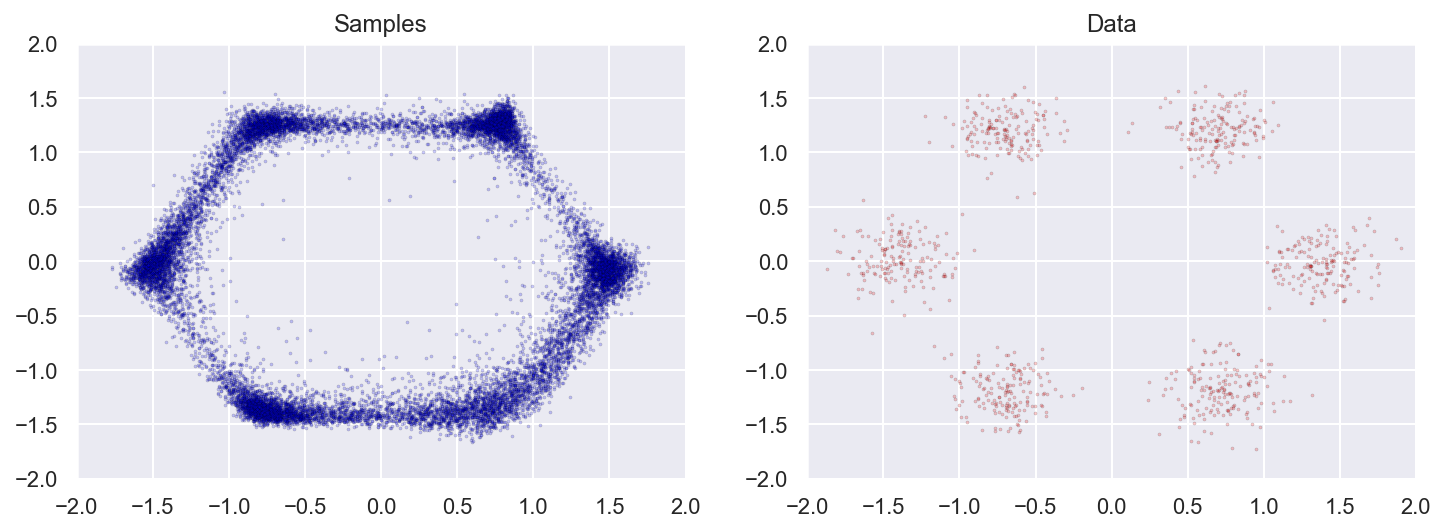

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(new_x[:,1], new_x[:,2], s=2.3, alpha=0.2, linewidths=0.3, c='blue', edgecolors='black')
plt.xlim(-2, 2) ; plt.ylim(-2, 2)
plt.title('Samples')

plt.subplot(122)
plt.scatter(X[:,0], X[:,1], s=2.3, alpha=0.2, c='red',  linewidths=0.3, edgecolors='black')
plt.xlim(-2, 2) ; plt.ylim(-2, 2)
plt.title('Data')

## without lightning

In [32]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-5)
epochs=300

hist_loss = []

with tqdm(total=epochs) as pbar:

    for i in range(epochs):
        
        for batch_idx, batch in enumerate(trainloader):
            
            x, _ = batch
            xtrJ = model(x)
            logprob = prior.log_prob(xtrJ[:,1:]).to(x) - xtrJ[:,0] # logp(z_S) = logp(z_0) - \int_0^S trJ
            loss = -torch.mean(logprob)
            nde.nfe = 0
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            hist_loss.append(loss.item())

            pbar.set_postfix(loss=loss.item())
            
        pbar.update()

  0%|          | 0/300 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Data')

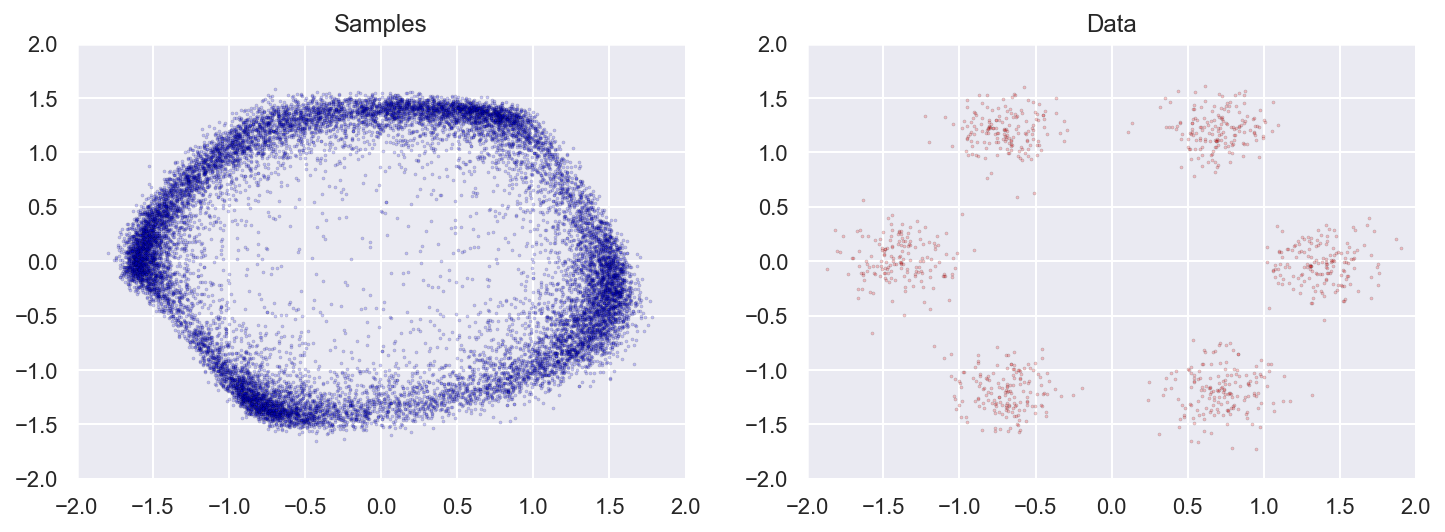

In [33]:
with torch.no_grad():
    prior = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))
    sample = prior.sample(torch.Size([1 << 14]))
    # integrating from 1 to 0
    model[1].s_span = torch.linspace(1, 0, 2)
    new_x = model(sample).cpu().detach()

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(new_x[:,1], new_x[:,2], s=2.3, alpha=0.2, linewidths=0.3, c='blue', edgecolors='black')
plt.xlim(-2, 2) ; plt.ylim(-2, 2)
plt.title('Samples')

plt.subplot(122)
plt.scatter(X[:,0], X[:,1], s=2.3, alpha=0.2, c='red',  linewidths=0.3, edgecolors='black')
plt.xlim(-2, 2) ; plt.ylim(-2, 2)
plt.title('Data')